In [275]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score

import warnings
warnings.filterwarnings('ignore')

Dataset: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
        
Features and information:

1. Date: The date of observation
2. Location: The common name of the location of the weather station
3. MinTemp: The minimum temperature in degrees celsius
4. MaxTemp: The maximum temperature in degrees celsius 
5. Rainfall: The amount of rainfall recorded for the day in mm
6. Evaporation: The so-called Class A pan evaporation (mm) in the 24 hours to 9am
7. Sunshine: The number of hours of bright sunshine in the day.
8. WindGustDir: The direction of the strongest wind gust in the 24 hours to midnight
9. WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
10. WindDir9am: Direction of the wind at 9am
11. WindDir3pm: Direction of the wind at 3pm
12. WindSpeed9am: Wind speed (km/hr) averaged over 10 minutes prior to 9am
13. WindSpeed3pm: Direction of the wind at 3pm
14. Humidity9am: Humidity (percent) at 9am:
15. Humidity3pm: Humidity (percent) at 3pm:
16. Pressure9am: Atmospheric pressure (hpa) reduced to mean sea level at 9am
17. Pressure3pm: Atmospheric pressure (hpa) reduced to mean sea level at 3pm
18. Cloud9am: Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many
19. Cloud3pm: Fraction of sky obscured by cloud at 3pm. This is measured in "oktas", which are a unit of eigths. It records how many
20. Temp9am: Temperature (degrees C) at 9am
21. Temp3pm: Temperature (degrees C) at 3pm
22. RainToday: Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
23. RainTomorrow: The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk".

# Data preparation and data cleaning

In [227]:
df = pd.read_csv("weatherAUS.csv",sep=",")
df.shape

(145460, 23)

**The data contains 145460 entries and 23 features**

In [228]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [229]:
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [230]:
df.RainToday = (df.RainToday == "Yes").astype(int) #converts yes to 1 and no to 0
df.RainTomorrow = (df.RainTomorrow == "Yes").astype(int) #converts yes to 1 and no to 0

In [231]:
df.describe().round()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,143975.0,144199.0,142199.0,82670.0,75625.0,135197.0,143693.0,142398.0,142806.0,140953.0,130395.0,130432.0,89572.0,86102.0,143693.0,141851.0,145460.0,145460.0
mean,12.0,23.0,2.0,5.0,8.0,40.0,14.0,19.0,69.0,52.0,1018.0,1015.0,4.0,5.0,17.0,22.0,0.0,0.0
std,6.0,7.0,8.0,4.0,4.0,14.0,9.0,9.0,19.0,21.0,7.0,7.0,3.0,3.0,6.0,7.0,0.0,0.0
min,-8.0,-5.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,980.0,977.0,0.0,0.0,-7.0,-5.0,0.0,0.0
25%,8.0,18.0,0.0,3.0,5.0,31.0,7.0,13.0,57.0,37.0,1013.0,1010.0,1.0,2.0,12.0,17.0,0.0,0.0
50%,12.0,23.0,0.0,5.0,8.0,39.0,13.0,19.0,70.0,52.0,1018.0,1015.0,5.0,5.0,17.0,21.0,0.0,0.0
75%,17.0,28.0,1.0,7.0,11.0,48.0,19.0,24.0,83.0,66.0,1022.0,1020.0,7.0,7.0,22.0,26.0,0.0,0.0
max,34.0,48.0,371.0,145.0,14.0,135.0,130.0,87.0,100.0,100.0,1041.0,1040.0,9.0,9.0,40.0,47.0,1.0,1.0


In [232]:
# Date could be changed into day, month and year, which would boost the prediction

months_dic = {
    1:'january',2:'feabruary',3:'march',4:'april',5:'may',6:'june',
    7:'july',8:'august',9:'september',10:'october',11:'november',12:'december'
}

def extract_date(x):
    years, months, days = [],[],[]
    for d in x.Date.values:
        year,month,day = d.split("-")
        years.append(int(year))
        months.append(int(month))
        days.append(int(day))
    return years, months, days

years, months, days = extract_date(df)
df["year"] = years
df["month"] = months
df["day"] = days
df.month = df.month.map(months_dic)
del df["Date"]

In [233]:
df.head(3)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,0,0,2008,december,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,0,0,2008,december,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,0,0,2008,december,3


## Split Dataset into Train/Val/Test (60%/20%/20%)

In [234]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print (len(df_train),len(df_test),len(df_val))

df_train = df_train.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.RainTomorrow.values
y_test = df_test.RainTomorrow.values
y_val = df_val.RainTomorrow.values

del df_train['RainTomorrow']
del df_test['RainTomorrow']
del df_val['RainTomorrow']


87276 29092 29092


In [235]:
df_train

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month,day
0,NorfolkIsland,11.2,20.6,0.0,NaN,NaN,NE,37.0,NNE,NNE,...,1018.8,1015.1,2.0,NaN,17.8,18.9,0,2016,october,23
1,Albury,3.6,19.0,0.0,NaN,NaN,SSW,28.0,SSE,WSW,...,1021.3,1018.1,NaN,NaN,10.8,18.2,0,2016,october,24
2,Perth,19.8,34.1,0.0,12.0,12.2,SSW,44.0,NW,SW,...,997.2,998.0,1.0,1.0,31.7,26.6,0,2011,january,13
3,Watsonia,14.0,15.0,13.8,7.6,0.1,SW,31.0,WSW,NNW,...,1015.0,1016.5,8.0,7.0,14.2,14.3,1,2016,april,6
4,MountGinini,4.6,14.8,0.0,NaN,NaN,WNW,46.0,WNW,WNW,...,NaN,NaN,NaN,NaN,9.0,13.0,0,2013,november,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87271,Newcastle,22.4,29.9,0.0,NaN,NaN,NaN,NaN,NE,NE,...,NaN,NaN,2.0,4.0,25.6,28.5,0,2011,january,13
87272,Walpole,9.8,14.7,9.2,NaN,NaN,SSW,46.0,WSW,SSW,...,1023.5,1025.4,NaN,NaN,12.5,13.0,1,2015,september,14
87273,Walpole,12.5,23.4,0.0,NaN,NaN,NW,50.0,NNE,NNW,...,1011.8,1004.6,NaN,NaN,15.4,21.6,0,2017,may,14
87274,Wollongong,12.8,18.0,0.0,NaN,NaN,S,37.0,SW,S,...,1026.9,1024.2,NaN,NaN,16.1,17.7,0,2017,may,9


# EDA and feature importance analysis

In [236]:
df.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday          int64
RainTomorrow       int64
year               int64
month             object
day                int64
dtype: object

In [257]:
def get_type(df):
    categorical = [col for col in df.columns if df[col].dtype == 'O'] #0 = Object
    numerical = [col for col in df.columns if df[col].dtype != 'O']
    
    return categorical, numerical

categorical, numerical = get_type(df_full_train)
numerical.remove("RainTomorrow")

print('Categorical features:', categorical)
print('Numerical features:', numerical)

Categorical features: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'month']
Numerical features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'year', 'day']


In [258]:
df_full_train[categorical].isnull().sum(axis = 0)

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
month          0
dtype: int64

In [259]:
df_full_train.head(5)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,MountGinini,-2.7,4.3,0.0,4.8,8.4,WSW,41.0,WSW,WSW,...,1015.2,5.0,5.0,-1.3,3.9,0,0,2015,august,29
1,SalmonGums,0.2,18.7,1.6,4.8,8.4,NE,37.0,NE,ENE,...,1015.2,5.0,5.0,11.7,18.1,1,0,2015,may,13
2,Walpole,7.0,13.8,0.2,4.8,8.4,SSW,61.0,NW,SSW,...,1012.8,5.0,5.0,12.2,9.9,0,1,2015,august,31
3,Perth,9.2,23.4,0.0,6.0,11.6,WNW,24.0,W,W,...,1016.1,2.0,1.0,19.4,22.2,0,0,2012,october,18
4,Perth,13.8,23.6,1.0,5.0,8.9,SW,33.0,SSW,SW,...,1014.0,7.0,4.0,19.6,22.0,0,0,2014,november,22


In [260]:
df_full_train[categorical].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
month          12
dtype: int64

In [261]:
df_full_train[numerical].nunique()

MinTemp          385
MaxTemp          498
Rainfall         642
Evaporation      337
Sunshine         144
WindGustSpeed     65
WindSpeed9am      42
WindSpeed3pm      43
Humidity9am      101
Humidity3pm      101
Pressure9am      536
Pressure3pm      536
Cloud9am          10
Cloud3pm          10
Temp9am          436
Temp3pm          495
RainToday          2
year              11
day               31
dtype: int64

In [262]:
df_full_train[categorical].isnull().sum(axis = 0)

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
month          0
dtype: int64

**We have NaNs in the direction of the wind. I will populate the NaNs depending on the direction at 9am. I assume that at 3pm the wind wont change much, and the direction of the strongest wind gust wont change neither. If I have NaN at 9am, I will use at 3pm, and if I also do not have data at 3pm, I will use WindGustDir**

In [263]:
for df1 in [df_full_train, df_train, df_val, df_test]:
    df1['WindGustDir'].fillna(df1['WindDir9am'], inplace=True)
    df1['WindDir3pm'].fillna(df1['WindDir9am'], inplace=True)
    
    df1['WindGustDir'].fillna(df1['WindDir3pm'], inplace=True)
    df1['WindDir9am'].fillna(df1['WindDir3pm'], inplace=True)
    
    df1['WindDir3pm'].fillna(df1['WindGustDir'], inplace=True)
    df1['WindDir9am'].fillna(df1['WindGustDir'], inplace=True)
    
df_full_train[categorical].isnull().sum()

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
month          0
dtype: int64

In [264]:
len(df_full_train[df_full_train[['WindGustDir','WindDir9am','WindDir3pm']].isna().all(axis=1)])

0

**There are 1465 entries with NaN in all 3 features for wind direction. I will remove these entries since they are only 1% of 145000 in total.**

In [265]:
for df1 in [df_full_train, df_train, df_val, df_test]:
    df1.dropna(subset=['WindGustDir','WindDir9am','WindDir3pm'], inplace=True)

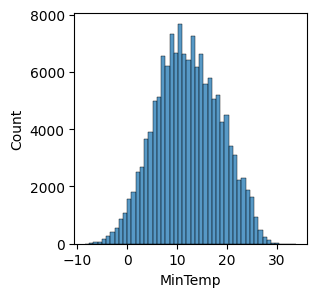

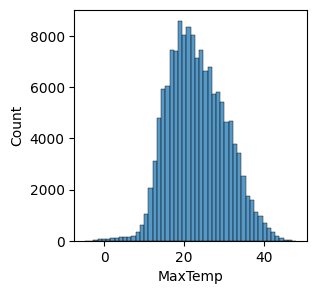

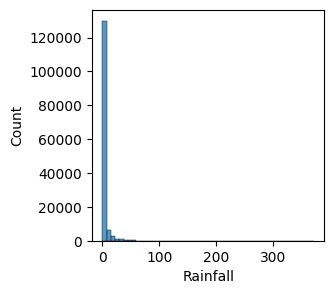

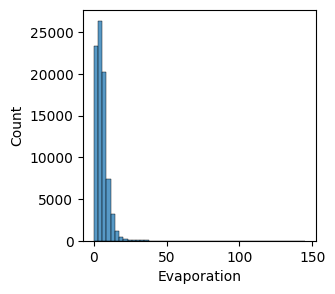

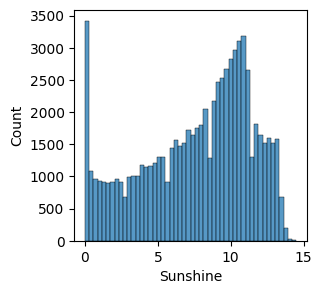

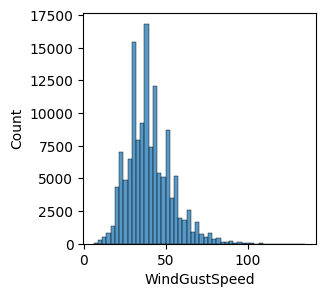

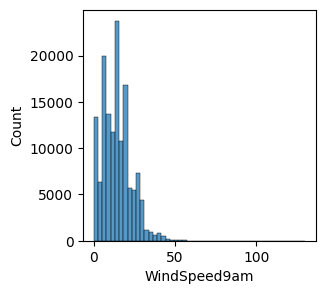

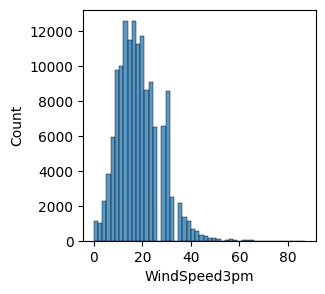

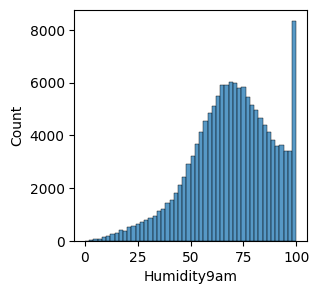

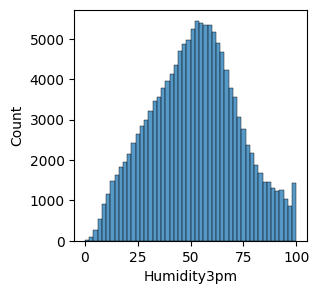

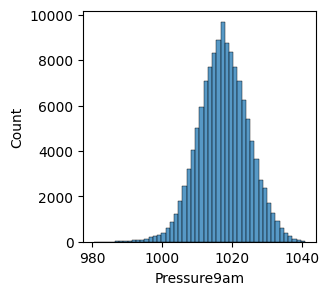

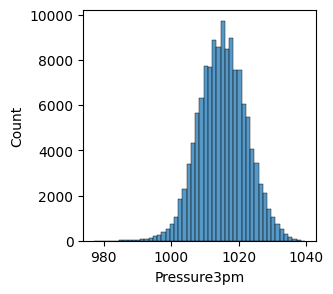

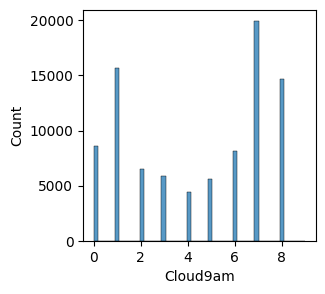

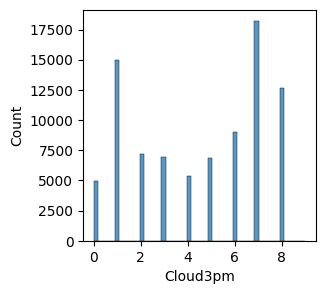

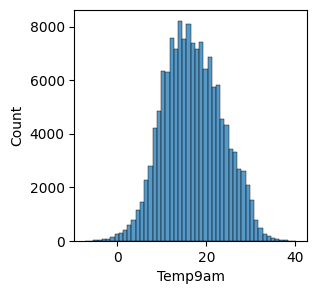

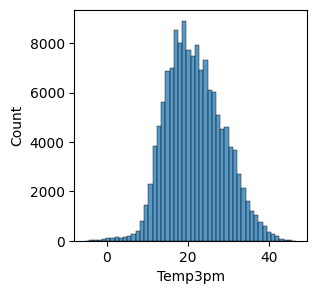

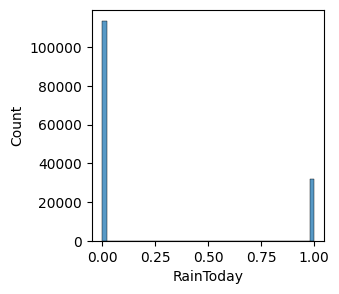

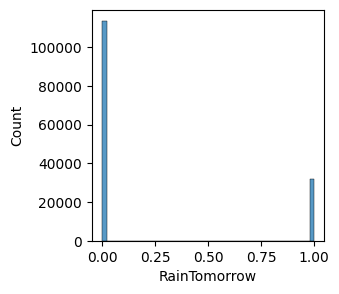

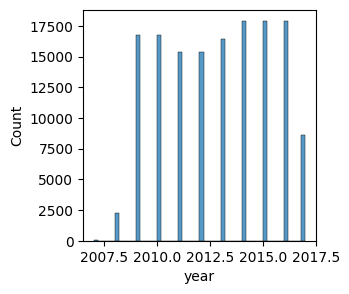

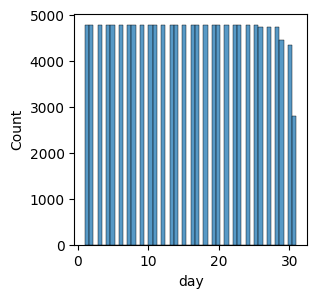

In [266]:
for i,col in enumerate (df_full_train.describe().columns):
    plt.figure(i,figsize=(3,3))
    sns.histplot(df[col],bins=50)

<AxesSubplot: >

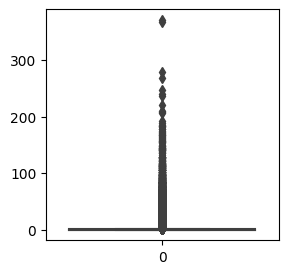

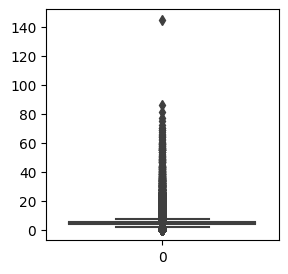

In [267]:
# Looks like Rainfall and Evaporation have some outliers
plt.figure(figsize=(3,3))
sns.boxplot(df_full_train["Rainfall"])
plt.figure(figsize=(3,3))
sns.boxplot(df_full_train["Evaporation"])

In [268]:
df_full_train[numerical].isnull().sum(axis = 0)

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
year             0
day              0
dtype: int64

In [269]:
# for the rest of the values, fill nans with median values since we have some outliers.
for df1 in [df_full_train, df_train, df_val, df_test]:
    for col in numerical:
        median_value = df_full_train[col].median() #use median of the full train
        df1[col].fillna(median_value, inplace=True) 
    

In [271]:
df_full_train.isnull().sum(axis = 0)

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
year             0
month            0
day              0
dtype: int64

In [272]:
df_full_train.RainTomorrow.value_counts(normalize=True)

0    0.780354
1    0.219646
Name: RainTomorrow, dtype: float64

## Feature importance

In [278]:
def mutual_info_rain_tomorrow_score(series):
    return mutual_info_score(series, df_full_train.RainTomorrow)

mi = df_full_train[categorical+numerical].apply(mutual_info_rain_tomorrow_score)
mi = mi.sort_values(ascending=False)
mi


Humidity3pm      0.108764
Rainfall         0.056188
Sunshine         0.055713
Cloud3pm         0.050626
RainToday        0.042072
Humidity9am      0.037463
Cloud9am         0.035348
Pressure9am      0.031150
Pressure3pm      0.027093
WindGustSpeed    0.025375
Temp3pm          0.022155
MaxTemp          0.016347
Location         0.013036
Evaporation      0.007425
WindDir9am       0.007340
MinTemp          0.007287
WindGustDir      0.005778
WindSpeed3pm     0.005267
WindDir3pm       0.004677
WindSpeed9am     0.004077
Temp9am          0.003948
month            0.001620
year             0.000664
day              0.000328
dtype: float64

# Model selection process and parameter tuning

We have learned the next algorithms for classification:
1. LogisticRegression()
2. DecisionTreeClassifier()
3. RandomForestClassifier()
4. XGBoost()

In [296]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)


In [301]:
# 1 Logistic Regression

from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer   
from sklearn.metrics import roc_auc_score  
from sklearn.metrics import auc


scores = []
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred).round(3)
   
    print ("C: {}, AUC: {}".format(C, auc))


C: 0.001, AUC: 0.865
C: 0.01, AUC: 0.87
C: 0.1, AUC: 0.868
C: 1, AUC: 0.866
C: 10, AUC: 0.871
C: 100, AUC: 0.869


BEST: C=10

In [305]:
# 2 Decission Tree

from sklearn.tree import DecisionTreeClassifier

scores = []
for d in [1,2,3,4,5,6,10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf = s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d,s,auc))
        #print ('%4s %s -> %.3f' % (d,s, auc))



   1 1 -> 0.690
   1 2 -> 0.690
   1 5 -> 0.690
   1 10 -> 0.690
   1 15 -> 0.690
   1 20 -> 0.690
   1 100 -> 0.690
   1 200 -> 0.690
   1 500 -> 0.690
   2 1 -> 0.769
   2 2 -> 0.769
   2 5 -> 0.769
   2 10 -> 0.769
   2 15 -> 0.769
   2 20 -> 0.769
   2 100 -> 0.769
   2 200 -> 0.769
   2 500 -> 0.769
   3 1 -> 0.795
   3 2 -> 0.795
   3 5 -> 0.795
   3 10 -> 0.795
   3 15 -> 0.795
   3 20 -> 0.795
   3 100 -> 0.795
   3 200 -> 0.795
   3 500 -> 0.795
   4 1 -> 0.816
   4 2 -> 0.816
   4 5 -> 0.816
   4 10 -> 0.816
   4 15 -> 0.816
   4 20 -> 0.816
   4 100 -> 0.816
   4 200 -> 0.816
   4 500 -> 0.816
   5 1 -> 0.828
   5 2 -> 0.828
   5 5 -> 0.828
   5 10 -> 0.828
   5 15 -> 0.828
   5 20 -> 0.828
   5 100 -> 0.828
   5 200 -> 0.828
   5 500 -> 0.828
   6 1 -> 0.838
   6 2 -> 0.838
   6 5 -> 0.838
   6 10 -> 0.838
   6 15 -> 0.838
   6 20 -> 0.838
   6 100 -> 0.838
   6 200 -> 0.837
   6 500 -> 0.836
  10 1 -> 0.839
  10 2 -> 0.842
  10 5 -> 0.843
  10 10 -> 0.846
  10 15 -> 0.848


In [321]:
columns = ["max_depth", "min_samples_leaf", "auc"]
df_scores = pd.DataFrame(scores, columns=columns)
print(df_scores.sort_values(by="auc",ascending=False))


    max_depth  min_samples_leaf       auc
70       15.0               200  0.854632
79       20.0               200  0.854433
88        NaN               200  0.854430
61       10.0               200  0.854025
60       10.0               100  0.853396
..        ...               ...       ...
5         1.0                20  0.689756
7         1.0               200  0.689756
8         1.0               500  0.689756
0         1.0                 1  0.689756
72       20.0                 1  0.688029

[90 rows x 3 columns]


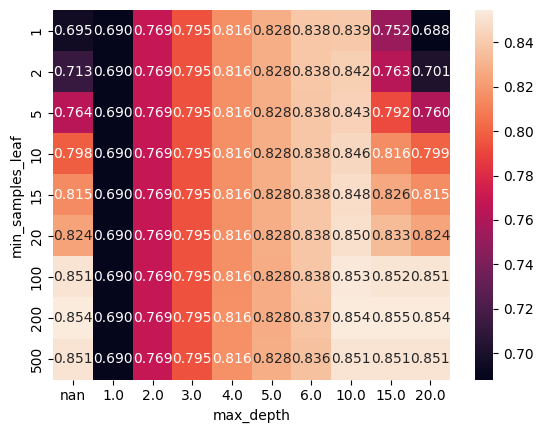

In [320]:
df_scores_pivot= df_scores.pivot(index='min_samples_leaf',columns=["max_depth"],values="auc")
sns.heatmap(df_scores_pivot,annot=True, fmt='.3f')
plt.show()


BEST: 

    max_depth  min_samples_leaf       auc
70       15.0               200  0.854632

5 10
5 30
5 50
5 70
5 90
5 110
5 130
5 150
5 170
5 190
10 10
10 30
10 50
10 70
10 90
10 110
10 130
10 150
10 170
10 190
15 10
15 30
15 50
15 70
15 90
15 110
15 130
15 150
15 170
15 190
20 10
20 30
20 50
20 70
20 90
20 110
20 130
20 150
20 170
20 190
25 10
25 30
25 50
25 70
25 90
25 110
25 130
25 150
25 170
25 190


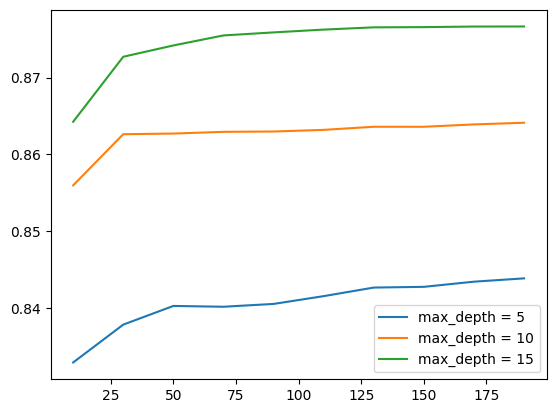

In [330]:
# 3 Random Forest

from sklearn.ensemble import RandomForestClassifier

scores = []
for d in [5, 10, 15, 20, 25]:
    for n in range(10, 201, 20):
        print (d,n)
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state = 1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n,auc))
df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators','auc'])



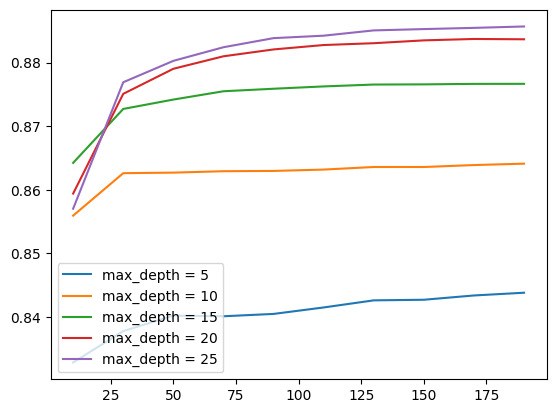

In [331]:
for d in [5, 10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc,label='max_depth = %s' % d)
plt.legend()
plt.show()

In [ ]:
#now tune min leaf
scores = []
max_depth = 15

for m in [1,3, 5, 10, 55]:
    for n in range(10, 201, 20):
        print (d,n)
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth,min_samples_leaf=m, random_state = 1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n,auc))
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf','n_estimators','auc'])
for m in [1,3, 5, 10, 55]:
    df_subset = df_scores[df_scores.min_samples_leaf == m]
    plt.plot(df_subset.n_estimators, df_subset.auc,label='min_samples_leaf = %s' % m)
plt.legend()
plt.show()

In [332]:
# 4 XGBoost

import xgboost as xgb

features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
xgb_params = {
        'eta': 0.3, #how fast it trains
        'max_depth': 6,
        'min_child_weight': 1,  #te same as min_samples_leaf
        'objective': 'binary:logistic', #becasue we have a binary class type
        'nthread': 8,
        'seed': 1,
        'verbosity':1,
        }
model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = model.predict(dval)
auc = roc_auc_score(y_val, y_pred)

print(auc) #for default parameters we get 0.80, pretty good


0.8701187771166792


In [334]:
from io import StringIO 
import sys

watchlist = [(dtrain, 'train'),(dval,'dval')]

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout



def parse_xgb_output(output):
    output = list(output)
    results = []

    #for line in output.strip().split(','):
    for line in output:
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it,train,val))

    columns = ['num_iter','train_auc','val_auc']
    df_results = pd.DataFrame(results,columns=columns)
    return df_results



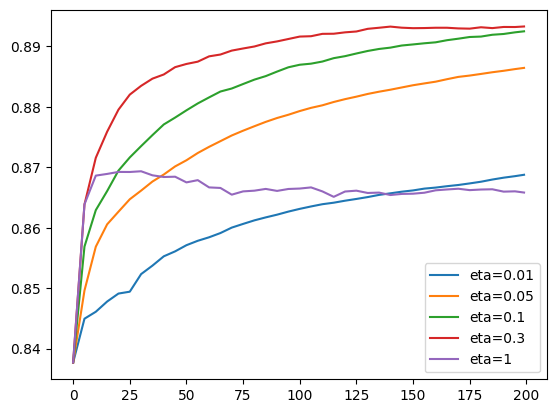

In [337]:
scores = {}
for etas in [0.01, 0.05,0.1,0.3,1]:
    xgb_params = {
            'eta': etas, #how fast it trains
            'max_depth': 6,
            'min_child_weight': 1,  #te same as min_samples_leaf
            'objective': 'binary:logistic', #becasue we have a binary class type
            'eval_metric':'auc',
            'nthread': 8,
            'seed': 1,
            'verbosity':1,
            }
    with Capturing() as output:
        model = xgb.train(xgb_params, dtrain, num_boost_round=200,evals=watchlist,verbose_eval=5)
    key = 'eta=%s' % (xgb_params['eta'])
    scores[key] = parse_xgb_output(output)

for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()
plt.show()


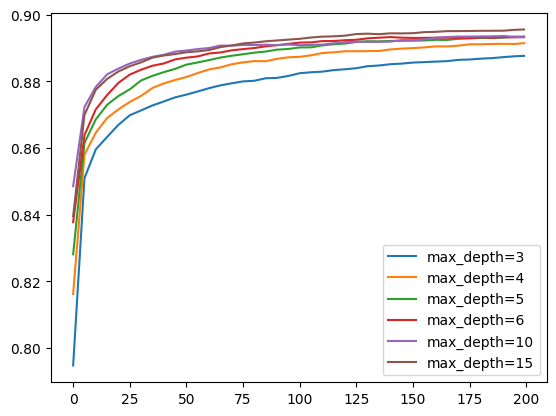

In [339]:
scores = {}
for d in [3, 4, 5, 6, 10, 15]:
    xgb_params = {
            'eta': 0.3, #how fast it trains
            'max_depth': d,
            'min_child_weight': 1,  #te same as min_samples_leaf
            'objective': 'binary:logistic', #becasue we have a binary class type
            'eval_metric':'auc',
            'nthread': 8,
            'seed': 1,
            'verbosity':1,
            }
    with Capturing() as output:
        model = xgb.train(xgb_params, dtrain, num_boost_round=200,evals=watchlist,verbose_eval=5)
    key = 'max_depth=%s' % (xgb_params['max_depth'])
    scores[key] = parse_xgb_output(output)

for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()
plt.show()
